<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S11/EVA4_Session_11_super_convergence_with_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S11 _Assignment 11_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **CIFAR10** |
  | _Max. number of epochs_| **24** |
  | _Max. number of parameters_| **NA** |
  | _Architecture_| **Custom Architecture** |
  | _Target accurracy_| **90%** |


# Implementation

## Initialization

### Mounting google drive to save results

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install torchsummary
!pip install torchviz
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 51kB 3.5MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=86f3de8a56871e6be106e43d15348e5aa10446051320441b8c3286731fb9adef
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-psf6vf_k
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-psf6vf_k
     |████████████████████████████████| 634kB 4.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=a620f67e39fc157191a32c9c8ab492a606474a9a3cb6835132861068aa56e74a
  Stored in directory: /tmp/pip-ephem-wheel-cache-fe9f27gx/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=3a225da5c8d1974e20a54c43427700b778e1f9ba5720

In [0]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import numpy as np

from torch.nn import functional as F
import cv2

# Code to plot the waveform

<h6><center>$cycle = floor(1 + \frac{iterations}{2(stepsize)})$</center></h6>

<h6><center>$lr_t = lr_{min} + (lr_{max} - lr_{min})(1 - x)$</center></h6>

<h6><center>$x = |\frac{iterations}{stepsize}\:-\:2\left(cycle\right)+1|$</center></h6>

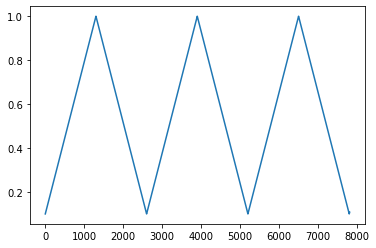

In [5]:
lr_min = 0.1
lr_max = 1.0

n_epochs = 20
batch_size = 128
n_samples = 50000

step_size = 1300

max_iterations = np.floor((n_samples / batch_size) * n_epochs)

iterations = np.arange(0, max_iterations)
cycle = np.floor(1 + (iterations / (2 * step_size)))
x = np.abs((iterations / step_size) - (2 * cycle) + 1)
lr_t = lr_min + (lr_max - lr_min) * (1 - x)

plt.plot(iterations, lr_t)

In [6]:
!rm -rf eva
!git clone "https://github.com/siva-sankar-a/eva.git"

Cloning into 'eva'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 541 (delta 155), reused 149 (delta 73), pack-reused 291
Receiving objects: 100% (541/541), 8.03 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [25]:
%load_ext autoreload
%autoreload 2
from eva.S11.api import Experiment
from eva.S11.data_manager.data_manager_albumentations import  DataManager
from eva.S11.viz import viz_cifar10_grid_
from eva.S11.utils import textual_summary_cifar10, graphical_summary_cifar10
from eva.S11.settings import cifar10_classes
from eva.S11.models.model_s11 import Net
from eva.S11.grad_cam.grad_cam import GradCam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create an instance of experiment class

In [35]:
experiment = Experiment(name=f'default', dataset_name='cifar10')

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified


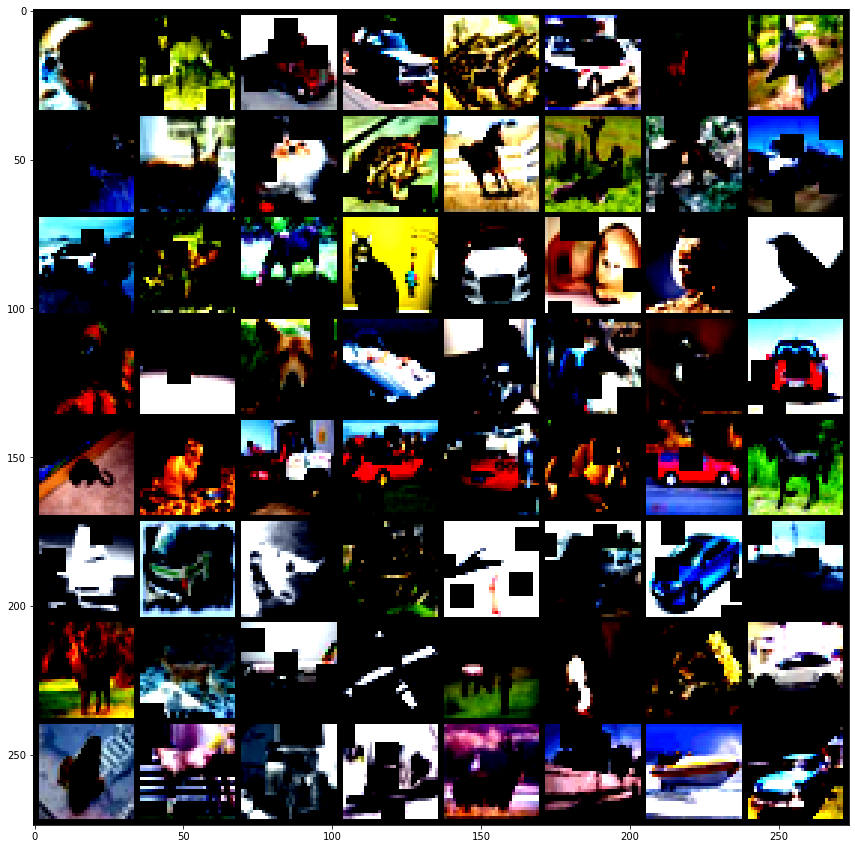

In [9]:
viz_cifar10_grid_(experiment.data_manager.train_loader)

In [10]:
textual_summary_cifar10(experiment.model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

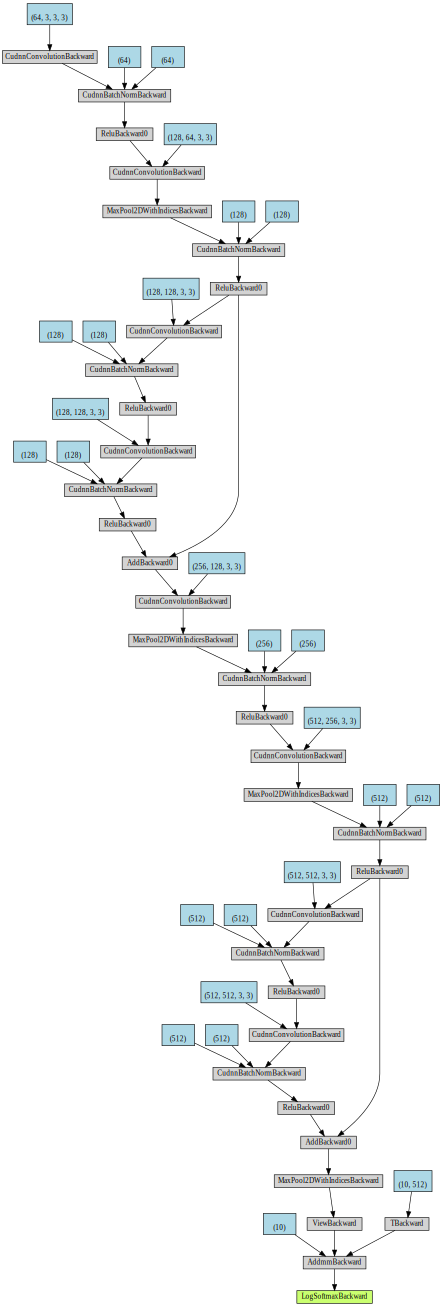

In [11]:
graphical_summary_cifar10(experiment.model)

# LR range test

In [0]:
momentum = 0.9
weight_decay = 0.01
max_lr = 0.25

In [64]:
experiment = Experiment(name=f'default', dataset_name='cifar10')
experiment.run(epochs=10, 
               momentum=0.9, 
               lr=max_lr, 
               regularization=None, 
               weight_decay=weight_decay, 
               max_lr=max_lr,
               epochs_up=10, 
               base_momentum=0.85,
               div_factor=1e6)

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified


TRAIN : epoch=0 train_loss=0.03196 correct/total=19361/50000 lr=0.03 accuracy=38.72: 100%|██████████| 782/782 [00:22<00:00, 34.42it/s]
TEST :  epoch=0 test_loss=2.26861 correct/total=4098/10000 accuracy=40.98: 100%|██████████| 157/157 [00:02<00:00, 75.48it/s]
TRAIN : epoch=1 train_loss=0.02138 correct/total=29932/50000 lr=0.05 accuracy=59.86: 100%|██████████| 782/782 [00:22<00:00, 34.94it/s]
TEST :  epoch=1 test_loss=0.93995 correct/total=6946/10000 accuracy=69.46: 100%|██████████| 157/157 [00:02<00:00, 75.80it/s]
TRAIN : epoch=2 train_loss=0.01276 correct/total=36054/50000 lr=0.08 accuracy=72.11: 100%|██████████| 782/782 [00:22<00:00, 34.66it/s]
TEST :  epoch=2 test_loss=0.69255 correct/total=7729/10000 accuracy=77.29: 100%|██████████| 157/157 [00:02<00:00, 73.09it/s]
TRAIN : epoch=3 train_loss=0.01069 correct/total=38228/50000 lr=0.10 accuracy=76.46: 100%|██████████| 782/782 [00:22<00:00, 34.62it/s]
TEST :  epoch=3 test_loss=0.65647 correct/total=7820/10000 accuracy=78.20: 100%|█████

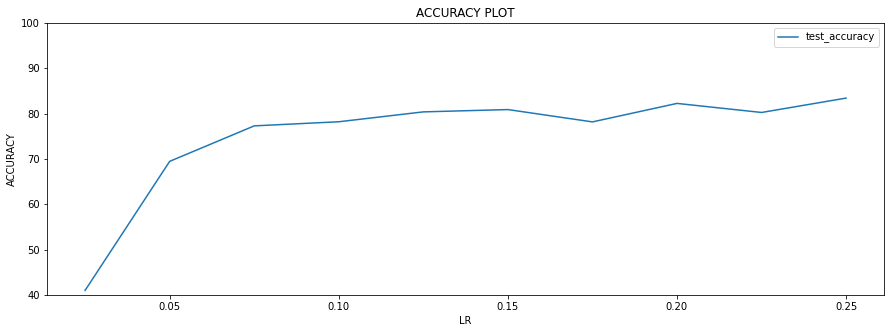

In [65]:
experiment.load_summary()
experiment.plot_lr_range_test_ocp()

Selected max_lr is 0.125 as accuracy stagnates between 0.13 and 0.15

# Training

In [0]:
momentum = 0.9
weight_decay = 0.01
max_lr = 0.125

In [54]:
experiment_ocp = Experiment(name=f'default', dataset_name='cifar10')

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified


In [55]:
experiment_ocp.run(epochs=24, 
                    momentum=0.9, 
                    lr=max_lr, 
                    regularization=None, 
                    weight_decay=weight_decay, 
                    max_lr=max_lr,
                    epochs_up=5, 
                    base_momentum=0.85,
                    div_factor=10)

TRAIN : epoch=0 train_loss=0.04367 correct/total=13627/50000 lr=0.04 accuracy=27.25: 100%|██████████| 782/782 [00:22<00:00, 35.47it/s]
TEST :  epoch=0 test_loss=1.62996 correct/total=4348/10000 accuracy=43.48: 100%|██████████| 157/157 [00:02<00:00, 76.21it/s]
TRAIN : epoch=1 train_loss=0.02024 correct/total=27465/50000 lr=0.06 accuracy=54.93: 100%|██████████| 782/782 [00:22<00:00, 35.32it/s]
TEST :  epoch=1 test_loss=1.01712 correct/total=6621/10000 accuracy=66.21: 100%|██████████| 157/157 [00:02<00:00, 77.01it/s]
TRAIN : epoch=2 train_loss=0.01409 correct/total=34392/50000 lr=0.08 accuracy=68.78: 100%|██████████| 782/782 [00:22<00:00, 35.21it/s]
TEST :  epoch=2 test_loss=0.86095 correct/total=7094/10000 accuracy=70.94: 100%|██████████| 157/157 [00:02<00:00, 74.49it/s]
TRAIN : epoch=3 train_loss=0.01161 correct/total=37220/50000 lr=0.10 accuracy=74.44: 100%|██████████| 782/782 [00:22<00:00, 35.02it/s]
TEST :  epoch=3 test_loss=0.63230 correct/total=7911/10000 accuracy=79.11: 100%|█████

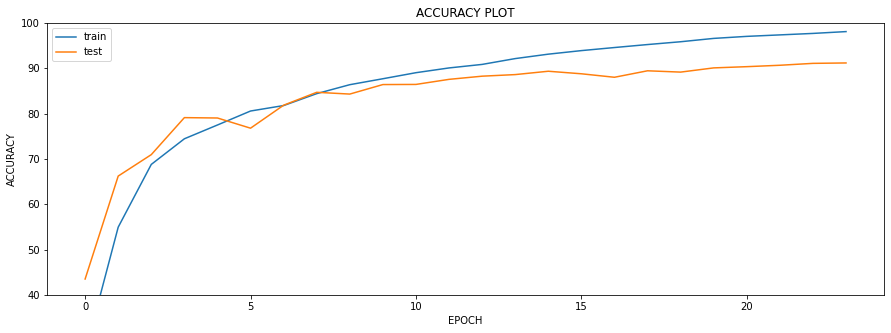

In [59]:
experiment_ocp.load_summary()
experiment_ocp.plot_metric()

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **98.1** |
| _Best test accuracy_| **91.18** |
| _Best epoch number_| **24** |
| _Parameter count_ | **6,573,130** |